# Load Dataset

In [2]:
# Import required libraries
import pickle
import os
import numpy as np

# Define the input directory where the processed dataset is stored
input_dir = "/kaggle/input/notebook455d9c1e14" 

# Construct the full file path for the final labeled dataset using os.path.join
file_path = os.path.join(input_dir, "final_labeled_dataset.pkl")

# Log the file path to confirm the dataset location
print(f"Loading dataset from: {file_path}")


try:
    # Attempt to open the pickle file in binary read mode
    with open(file_path, 'rb') as f:

        # Deserialize the processed dataset into memory
        processed_data = pickle.load(f)
    
    # Confirm successful loading and report the dataset size (number of audio clips)
    print(f"\n Successfully loaded {len(processed_data)} labeled audio clips.")
    
    # Display a sample record from the dataset for quick inspection
    print("\n--- Example of one data point: ---")
    sample = processed_data[0]     # Access the first sample from the dataset

    # Print metadata and array shapes for the sample
    print(f"  Label: {sample['label']}")    # Output the assigned label
    print(f"  Sample Rate: {sample['sample_rate']} Hz")     # Output the sample rate in Hz
    print(f"  IHM Audio Shape: {sample['ihm_audio'].shape}")     # Dimensions of IHM audio array
    print(f"  SDM Audio Shape: {sample['sdm_audio'].shape}")     # Dimensions of SDM audio array
    

except FileNotFoundError:

    # Handle the case where the specified file is missing
    print(f"\n ERROR: File not found at '{file_path}'.")
    print("The folder name is still incorrect. Please double-check the output of the '!ls /kaggle/input/' command.")

Loading dataset from: /kaggle/input/notebook455d9c1e14/final_labeled_dataset.pkl

 Successfully loaded 17997 labeled audio clips.

--- Example of one data point: ---
  Label: Alone / Quiet
  Sample Rate: 16000 Hz
  IHM Audio Shape: (48000,)
  SDM Audio Shape: (48000,)


-----------------------------------------------------------------

# Setup and Imports

In [3]:
# Step1: Import all the Necessary Libraries

# For loading our data and handling arrays
import pickle
import os
import numpy as np
import pandas as pd

# For audio feature extraction
import librosa
import librosa.display
import matplotlib.pyplot as plt

# PyTorch, our deep learning framework
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Tool for splitting our data
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# To make our progress bars look nice
from tqdm.notebook import tqdm

print("All libraries imported successfully!")

All libraries imported successfully!


----------------------------

# Load and Inspect Your Dataset

In [4]:
# Step 2: Load the processed dataset from the Kaggle input directory

# Define the base directory containing the processed dataset.
# Ensure that the folder name ('notebook455d9c1e14') matches exactly
# with the folder name listed in the Kaggle "Input" panel.
input_dir = "/kaggle/input/notebook455d9c1e14" 

# Construct the complete file path to the serialized dataset (.pkl file)
file_path = os.path.join(input_dir, "final_labeled_dataset.pkl")

# Log the file path to confirm the dataset being accessed
print(f"Loading dataset from: {file_path}...")

# Open the pickle file in binary read mode and load it into memory
with open(file_path, 'rb') as f:
    processed_data = pickle.load(f)

# Report the total number of labeled audio samples successfully loaded
print(f"\n Success! We've loaded {len(processed_data)} labeled audio clips.")

# Convert the dataset into a Pandas DataFrame for easier inspection and analysis
df = pd.DataFrame(processed_data)

# Display a summary of dataset distribution by label
print("\n--- Dataset Distribution ---")
print(df['label'].value_counts())

Loading dataset from: /kaggle/input/notebook455d9c1e14/final_labeled_dataset.pkl...

 Success! We've loaded 17997 labeled audio clips.

--- Dataset Distribution ---
label
Speech / Monologue         5971
Noisy Environment          5971
One-on-One Conversation    4295
Group Discussion           1556
Alone / Quiet               204
Name: count, dtype: int64


-----------------------------------------------

# Feature Extraction

*This is a crucial step. A neural network needs numbers, not sound waves. We'll write a function to convert each 3-second audio clip into a Mel Spectrogram. Think of this as turning our sound into a special kind of image that the model can learn from.*

--- Example Mel Spectrogram ---
Shape of the spectrogram: (128, 188)


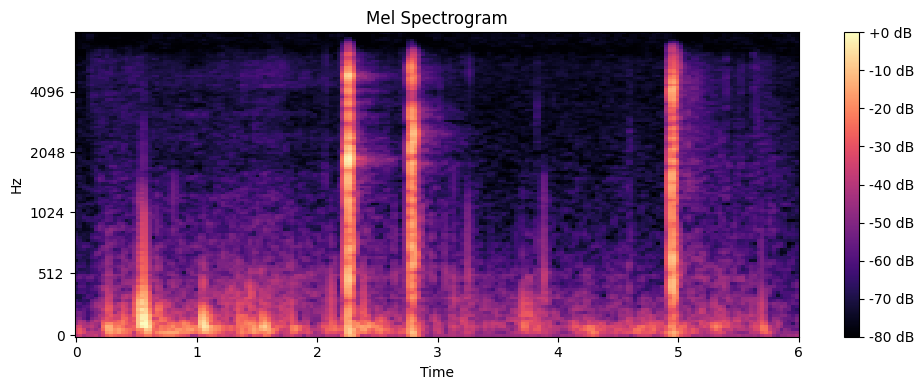

In [5]:
# Step 3: Define Feature Extraction Function

# Define a feature extraction function to convert raw audio signals into Mel Spectrograms
def audio_to_mel_spectrogram(audio_clip, sample_rate=16000):

    """
    Convert a 1D audio signal into a log-scaled Mel Spectrogram.
    Args:
        audio_clip (np.ndarray): Raw audio waveform.
        sample_rate (int): Sampling rate of the audio signal (default = 16 kHz).
    Returns:
        np.ndarray: Log-scaled Mel Spectrogram representation.
    """
    

    # Librosa is the best tool for this job. It does all the complex math for us
    # Compute the Mel Spectrogram:
    # - y: input audio signal
    # - sr: sample rate
    # - n_fft: number of samples per FFT window (defines frequency resolution)
    # - hop_length: step size for window sliding (controls time resolution)
    # - n_mels: number of Mel bands to generate
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_clip, 
                                                     sr=sample_rate, 
                                                     n_fft=1024,
                                                     hop_length=256,
                                                     n_mels=128)
    
    # Convert the spectrogram from a power scale to decibels (logarithmic scale)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    # Return the processed log-Mel Spectrogram
    return log_mel_spectrogram


# Extract an example Mel Spectrogram from the first IHM audio clip in the dataset
example_audio = processed_data[0]['ihm_audio']
example_spectrogram = audio_to_mel_spectrogram(example_audio)

# Log the shape of the computed spectrogram for verification
print("--- Example Mel Spectrogram ---")
print(f"Shape of the spectrogram: {example_spectrogram.shape}")

# Visualize the computed Mel Spectrogram using librosa's display utilities
plt.figure(figsize=(10, 4))     # Set figure size for readability

librosa.display.specshow(example_spectrogram,
                         sr=16000,
                         x_axis='time',
                         y_axis='mel')    # Display with time on x-axis and Mel frequencies on y-axis

plt.colorbar(format='%+2.0f dB')     # Add colorbar representing dB scale
plt.title('Mel Spectrogram')         # Add plot title
plt.tight_layout()                   # Optimize layout for display
plt.show()                           # Render the visualization

------------------------

# Create a Custom PyTorch Dataset

*To feed our data to the model efficiently, we need to wrap it in a custom PyTorch Dataset class. This class will handle everything: picking a sample, converting its audio to a spectrogram, and giving both the spectrogram (the input) and its label (the output) to the model.*

In [7]:
# Step 4: Define a custom dataset class compatible with PyTorch's DataLoader

# This class specifies how our audio data should be stored, accessed, and preprocessed
# before being passed into a PyTorch model.
class SocialContextDataset(Dataset):
    def __init__(self, data, feature_extractor):

        # Store the dataset (list of audio samples and labels)
        self.data = data

        # Store the feature extraction function to convert raw audio into spectrograms
        self.feature_extractor = feature_extractor
        
        # Create a mapping from string labels (e.g., "Group Discussion") to integer indices
        # This is required since machine learning models operate on numeric labels
        self.label_map = {label: i for i, label in enumerate(np.unique([d['label'] for d in data]))}

        # Create a reverse mapping for reference (index → label)
        self.class_names = {i: label for label, i in self.label_map.items()}

        # Print the generated label mapping for verification
        print("Label mapping created:")
        print(self.label_map)

    
    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.data)

    def __getitem__(self, idx):
        # Retrieve the sample at the given index
        sample = self.data[idx]
        
        # Extract the IHM (Individual Headset Microphone) audio signal,
        # which is typically cleaner than other sources
        audio_clip = sample['ihm_audio'].astype(np.float32)
        
        # Apply the feature extractor to convert the audio signal into a spectrogram
        spectrogram = self.feature_extractor(audio_clip)
        
        # Add a channel dimension to match the expected input format (e.g., 1 × H × W)
        spectrogram = np.expand_dims(spectrogram, axis=0)
        
        # Convert the textual label into its corresponding numeric ID
        label = self.label_map[sample['label']]
        
        # Return both the spectrogram and label as PyTorch tensors
        return torch.tensor(spectrogram), torch.tensor(label)


# Instantiate the dataset with all available samples.
# The dataset will later be split into training, validation, and test sets.
full_dataset = SocialContextDataset(processed_data, audio_to_mel_spectrogram)

Label mapping created:
{'Alone / Quiet': 0, 'Group Discussion': 1, 'Noisy Environment': 2, 'One-on-One Conversation': 3, 'Speech / Monologue': 4}


--------------------------------

# Split the Data and Create DataLoaders

*Split the 17,997 samples into training, validation, and test sets. This is crucial for making sure our model is actually learning and not just memorizing the data. We'll then create DataLoaders, which are PyTorch tools that efficiently feed data to the GPU in batches.*

In [13]:
# Step 5: Split the dataset into training, validation, and test sets, and prepare PyTorch DataLoaders

# Extract numeric labels for all samples to enable stratified splitting 
# (ensuring each split maintains the same label distribution as the full dataset).
labels = [full_dataset.label_map[d['label']] for d in processed_data]

# Perform the first split:
# - Create a test set consisting of 15% of the dataset.
# - The test set remains untouched until the final evaluation stage.
# - Stratified sampling ensures balanced class representation.
train_val_indices, test_indices, _, _ = train_test_split(
    range(len(full_dataset)), labels, test_size=0.15, random_state=42, stratify=labels)

# Perform the second split:
# - Split the remaining 85% into training and validation sets.
# - Validation set is ~15% of the total data (calculated as 0.18 of 85% ≈ 15%).
# - Again, stratified sampling preserves class balance.
train_indices, val_indices, _, _ = train_test_split(
    train_val_indices, [labels[i] for i in train_val_indices], test_size=0.18, random_state=42, stratify=[labels[i] for i in train_val_indices]) # 0.18 * 0.85 = ~15%

# Create dataset subsets using the computed indices
train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
val_dataset = torch.utils.data.Subset(full_dataset, val_indices)
test_dataset = torch.utils.data.Subset(full_dataset, test_indices)

# Report the number of samples in each split
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Initialize DataLoaders for efficient data handling during training:
# - DataLoader batches the data and optionally shuffles it.
# - num_workers specifies parallel data loading processes.
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Confirm that DataLoaders are ready for use in model training and evaluation
print("\n DataLoaders are ready!")

Training set size: 12543
Validation set size: 2754
Test set size: 2700

 DataLoaders are ready!


------------------------------------

# Build the Neural Network

*Define the architecture of our Convolutional Neural Network (CNN). I've designed a simple but powerful model that is perfect for this task. It has a series of convolutional layers to find patterns in the spectrogram "images" and fully connected layers to make the final classification.*

In [9]:
# Step 6: Define the Convolutional Neural Network (CNN) architecture for audio classification

# Define a custom CNN model by subclassing PyTorch's nn.Module.
# This class encapsulates both the feature extraction (convolutional layers)
# and classification (fully connected layers) stages of the network.
class AudioClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(AudioClassifierCNN, self).__init__()
        
        # Convolutional Block 1:
        # - Input: spectrogram with 1 channel (grayscale-like format).
        # - Learns low-level audio features such as frequency edges and simple patterns.
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),    # Normalize activations for stable training
            nn.ReLU(),             # Non-linearity to introduce feature complexity
            nn.MaxPool2d(kernel_size=2, stride=2)    # Downsample to reduce spatial dimensions
        )
        
        # Convolutional Block 2:
        # - Builds on features from conv1.
        # - Detects more complex frequency-time patterns such as harmonics or modulations.
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Convolutional Block 3:
        # - Extracts high-level abstract features that correspond to distinctive audio signatures.
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Flatten layer to convert 3D feature maps into a 1D vector for the classifier
        self.flatten = nn.Flatten()
        
        # Fully connected classifier:
        # - Transforms extracted features into class scores.
        # - Dropout regularization is applied to mitigate overfitting.
        self.classifier = nn.Sequential(
            nn.Linear(in_features=64 * 16 * 23, out_features=128), # The input features will need to be calculated based on spectrogram size
            nn.ReLU(),
            nn.Dropout(0.5), # Dropout is a technique to prevent overfitting.
            nn.Linear(in_features=128, out_features=num_classes)   # Final layer outputs logits for each class
        )

    def forward(self, x):
        # Define the forward propagation sequence
        x = self.conv1(x)       # Extract low-level features
        x = self.conv2(x)       # Extract mid-level features
        x = self.conv3(x)       # Extract high-level features
        x = self.flatten(x)     # Flatten for classifier input
        x = self.classifier(x)  # Compute class scores
        return x


# Instantiate the model with the correct number of output classes.
num_classes = len(full_dataset.label_map)
model = AudioClassifierCNN(num_classes)

# Print model architecture for verification
print("--- Model Architecture ---")
print(model)

# Detect and set computation device:
# - Use GPU ("cuda") if available for faster training, otherwise fall back to CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"\nModel is running on: {device}")

--- Model Architecture ---
AudioClassifierCNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0)

--------------

# The Training Loop

*We'll define a training loop that feeds data to the model, calculates how wrong its predictions are (the "loss"), and uses an "optimizer" to update the model's parameters to get better. We'll run this loop for a set number of epochs.*

In [14]:
# Step 7: Train the model

# Define loss function:
# CrossEntropyLoss is standard for multi-class classification tasks,
# as it combines softmax activation with negative log-likelihood loss.
criterion = nn.CrossEntropyLoss()

# Define optimizer:
# Adam optimizer adapts learning rates for each parameter,
# generally achieving faster convergence compared to vanilla SGD.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training configuration:
NUM_EPOCHS = 30  # Maximum number of epochs to train
PATIENCE = 5     # Stop training if validation loss does not improve for 'PATIENCE' consecutive epochs

# Keep track of the best performance and save that model
best_val_loss = float('inf')
epochs_no_improve = 0
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

print("--- Starting Extended Model Training with Early Stopping ---")


for epoch in range(NUM_EPOCHS):
    # --- Training Phase ---
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Iterate through mini-batches of training data
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Training]"):

        # Move data to the selected device (GPU/CPU)
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Reset gradients from previous batch
        optimizer.zero_grad()
        
        # Forward pass: compute predictions
        outputs = model(inputs)
        
        # Compute loss between predictions and true labels
        loss = criterion(outputs, labels)
        
        # Backward pass: compute gradients
        loss.backward()
        
        # Update weights based on gradients
        optimizer.step()

        # Track loss and accuracy for this batch
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)     # Get predicted class indices
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    # Disable gradient calculation to speed up validation
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Validation]"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass only
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track validation loss and accuracy
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    
    # Calculate and store the metrics for this epoch
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_val_loss = val_loss / len(val_loader.dataset)
    train_acc = correct_train / total_train
    val_acc = correct_val / total_val

    # Save metrics to history for later visualization/analysis
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    # Print summary for this epoch
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} -> Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

    
    # --- Early Stopping Logic ---
    # Check if the validation loss has improved.
    if avg_val_loss < best_val_loss:
        
        # If it has, we've found a new best model!
        # Validation improved: reset patience counter and save model checkpoint
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # Save the model's state to a file. This is our new champion.
        torch.save(model.state_dict(), 'best_model.pth')
        print("  Validation loss improved, saving new best model.")
        
    else:
        # Validation did not improve: increment patience counter
        epochs_no_improve += 1
        print(f"  Validation loss did not improve for {epochs_no_improve} epoch(s).")

    # If patience limit is reached, stop training early to prevent overfitting
    if epochs_no_improve >= PATIENCE:
        print(f"\nEarly stopping triggered after {PATIENCE} epochs with no improvement.")
        break

print("\n Training complete!")

--- Starting Extended Model Training with Early Stopping ---


Epoch 1/30 [Training]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 1/30 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 1/30 -> Train Loss: 0.9452, Train Acc: 0.6106 | Val Loss: 0.6809, Val Acc: 0.6612
  Validation loss improved, saving new best model.


Epoch 2/30 [Training]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 2/30 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 2/30 -> Train Loss: 0.7240, Train Acc: 0.6405 | Val Loss: 0.6872, Val Acc: 0.6601
  Validation loss did not improve for 1 epoch(s).


Epoch 3/30 [Training]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 3/30 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 3/30 -> Train Loss: 0.7014, Train Acc: 0.6473 | Val Loss: 0.6593, Val Acc: 0.6688
  Validation loss improved, saving new best model.


Epoch 4/30 [Training]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 4/30 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 4/30 -> Train Loss: 0.6914, Train Acc: 0.6487 | Val Loss: 0.6417, Val Acc: 0.6732
  Validation loss improved, saving new best model.


Epoch 5/30 [Training]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 5/30 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 5/30 -> Train Loss: 0.6868, Train Acc: 0.6549 | Val Loss: 0.6367, Val Acc: 0.6972
  Validation loss improved, saving new best model.


Epoch 6/30 [Training]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 6/30 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 6/30 -> Train Loss: 0.6653, Train Acc: 0.6662 | Val Loss: 0.6194, Val Acc: 0.6964
  Validation loss improved, saving new best model.


Epoch 7/30 [Training]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 7/30 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 7/30 -> Train Loss: 0.6533, Train Acc: 0.6766 | Val Loss: 0.6360, Val Acc: 0.6903
  Validation loss did not improve for 1 epoch(s).


Epoch 8/30 [Training]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 8/30 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 8/30 -> Train Loss: 0.6398, Train Acc: 0.6918 | Val Loss: 0.6272, Val Acc: 0.7052
  Validation loss did not improve for 2 epoch(s).


Epoch 9/30 [Training]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 9/30 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 9/30 -> Train Loss: 0.6324, Train Acc: 0.6955 | Val Loss: 0.6024, Val Acc: 0.7208
  Validation loss improved, saving new best model.


Epoch 10/30 [Training]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 10/30 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 10/30 -> Train Loss: 0.6328, Train Acc: 0.6950 | Val Loss: 0.6437, Val Acc: 0.7048
  Validation loss did not improve for 1 epoch(s).


Epoch 11/30 [Training]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 11/30 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 11/30 -> Train Loss: 0.6082, Train Acc: 0.7096 | Val Loss: 0.5763, Val Acc: 0.7451
  Validation loss improved, saving new best model.


Epoch 12/30 [Training]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 12/30 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 12/30 -> Train Loss: 0.5889, Train Acc: 0.7251 | Val Loss: 0.7715, Val Acc: 0.6975
  Validation loss did not improve for 1 epoch(s).


Epoch 13/30 [Training]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 13/30 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 13/30 -> Train Loss: 0.5938, Train Acc: 0.7202 | Val Loss: 0.5649, Val Acc: 0.7495
  Validation loss improved, saving new best model.


Epoch 14/30 [Training]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 14/30 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 14/30 -> Train Loss: 0.5620, Train Acc: 0.7396 | Val Loss: 0.5722, Val Acc: 0.7397
  Validation loss did not improve for 1 epoch(s).


Epoch 15/30 [Training]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 15/30 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 15/30 -> Train Loss: 0.5564, Train Acc: 0.7417 | Val Loss: 0.5511, Val Acc: 0.7476
  Validation loss improved, saving new best model.


Epoch 16/30 [Training]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 16/30 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 16/30 -> Train Loss: 0.5376, Train Acc: 0.7509 | Val Loss: 0.5660, Val Acc: 0.7407
  Validation loss did not improve for 1 epoch(s).


Epoch 17/30 [Training]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 17/30 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 17/30 -> Train Loss: 0.5271, Train Acc: 0.7529 | Val Loss: 0.5567, Val Acc: 0.7596
  Validation loss did not improve for 2 epoch(s).


Epoch 18/30 [Training]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 18/30 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 18/30 -> Train Loss: 0.5148, Train Acc: 0.7631 | Val Loss: 0.5797, Val Acc: 0.7513
  Validation loss did not improve for 3 epoch(s).


Epoch 19/30 [Training]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 19/30 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 19/30 -> Train Loss: 0.4939, Train Acc: 0.7688 | Val Loss: 0.5590, Val Acc: 0.7520
  Validation loss did not improve for 4 epoch(s).


Epoch 20/30 [Training]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 20/30 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 20/30 -> Train Loss: 0.4851, Train Acc: 0.7748 | Val Loss: 0.5586, Val Acc: 0.7498
  Validation loss did not improve for 5 epoch(s).

Early stopping triggered after 5 epochs with no improvement.

 Training complete!


------------------------

# Evaluate the Results

*After training, lets see how well our model performs. We'll plot the training history to see if it learned well, and then we'll unleash it on the test set the data it has never seen before to get a final, unbiased measure of its accuracy.*

Loading the champion model for final evaluation...


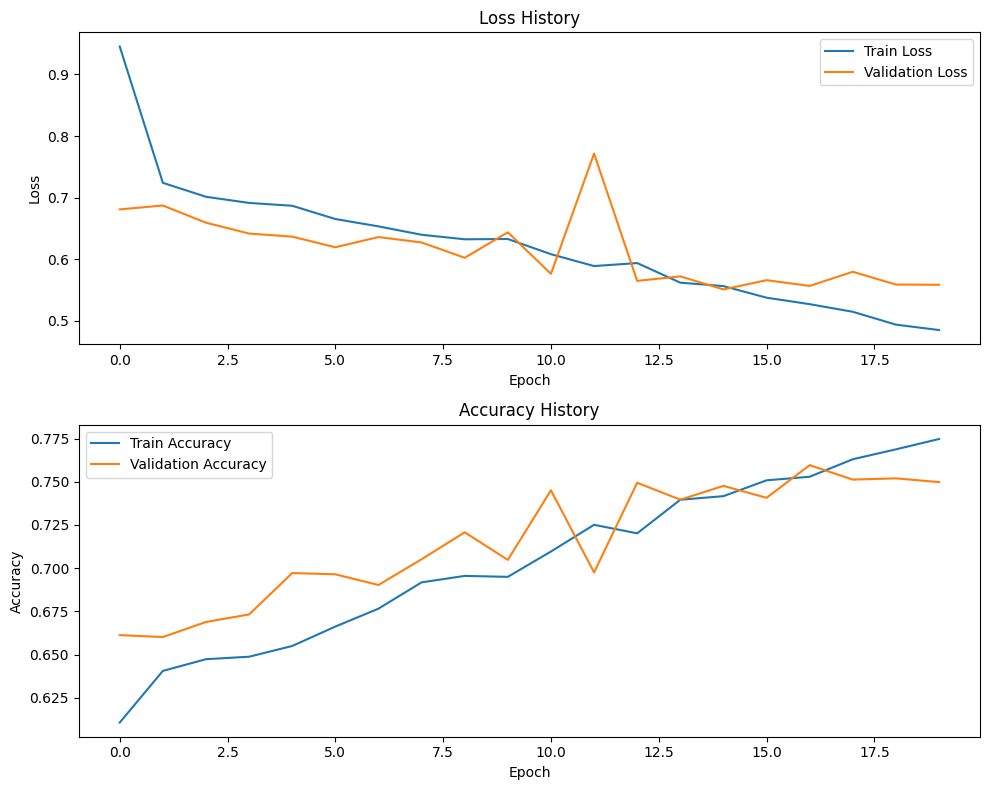

Testing:   0%|          | 0/85 [00:00<?, ?it/s]


--- Classification Report ---
                         precision    recall  f1-score   support

          Alone / Quiet       0.83      0.32      0.47        31
       Group Discussion       0.64      0.41      0.50       233
      Noisy Environment       1.00      1.00      1.00       896
One-on-One Conversation       0.52      0.59      0.55       644
     Speech / Monologue       0.72      0.74      0.73       896

               accuracy                           0.76      2700
              macro avg       0.74      0.61      0.65      2700
           weighted avg       0.76      0.76      0.75      2700


--- Confusion Matrix ---


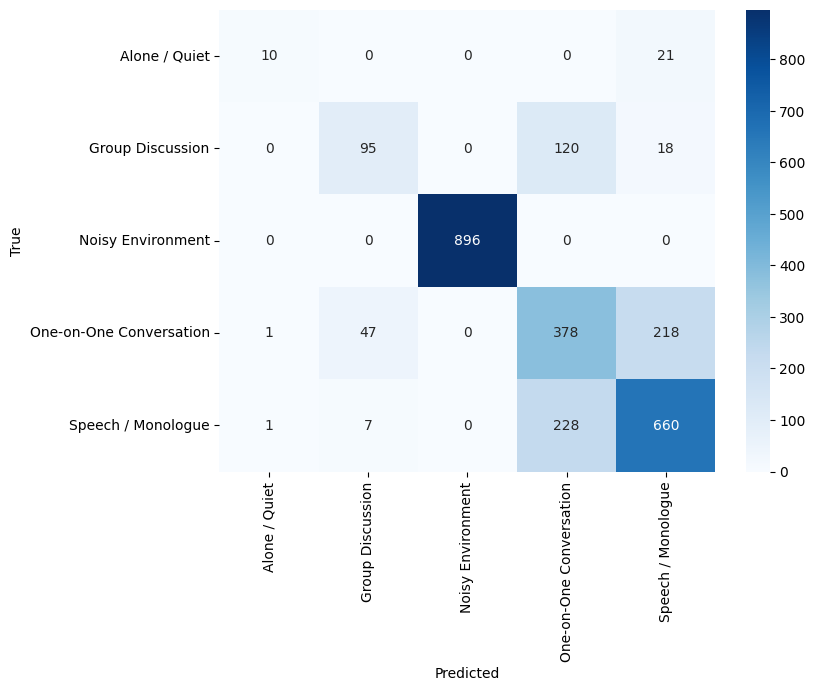


--- PROJECT COMPLETE! ---


In [15]:
# Step 8: Visualize Training History and Evaluate on the Test Set

# Print a message indicating that the best saved model is being loaded for evaluation
print("Loading the champion model for final evaluation...")

# Load the trained weights from disk into the final_model instance
final_model.load_state_dict(torch.load('best_champion_model.pth'))

# Create a figure with two vertically stacked subplots for loss and accuracy visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot training vs validation loss to analyze convergence behavior
ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['val_loss'], label='Validation Loss')
ax1.set_title('Loss History')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot training vs validation accuracy to evaluate generalization
ax2.plot(history['train_acc'], label='Train Accuracy')
ax2.plot(history['val_acc'], label='Validation Accuracy')
ax2.set_title('Accuracy History')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Optimize layout and display performance curves
plt.tight_layout()
plt.show()

# --- Final Evaluation on the Test Set ---
model.eval()
all_preds = []
all_labels = []

# Iterate through test dataset batches and collect predictions
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Map class indices back to human-readable class names
class_names = [full_dataset.class_names[i] for i in range(len(full_dataset.class_names))]

# Generate classification report with precision, recall, and F1 metrics
print("\n--- Classification Report ---")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Compute and plot confusion matrix to visualize misclassification patterns
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

---------------------------